In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from os import path
from quenching import calc_quenched_flour, fit_quenching_linear, mark_non_quenchers
from quenching import well_mean_with_error_propagation

In [2]:
# Load data from in-vitro RTDP plate reader experiments. 
long_df_pre = pd.read_csv('../data/O2NS_vitro/O2NS_long_df_pre.csv', index_col=0)
long_df_post = pd.read_csv('../data/O2NS_vitro/O2NS_long_df_post.csv', index_col=0)

# Drop first timepoint to match our treatment of in-vitro RTDP measurements
long_df_pre = long_df_pre[long_df_pre.time_s > 0]
long_df_post = long_df_post[long_df_post.time_s > 0]

# Infer the quenched fluorescence by comparing pre/post measurements
long_df_pre, long_df_post, blank_vals, pt_alone_fluors = calc_quenched_flour(
    long_df_pre, long_df_post, "pt_fluor", "O2NS")

# In this case data comes from a single date, so there is only one blank (mean+/-std) and reference value.
blank_val = blank_vals.iloc[0]
pt_alone_fluor = pt_alone_fluors.iloc[0]

long_df_pre.to_csv("../data/O2NS_vitro/O2NS_long_df_pre_processed.csv")
long_df_post.to_csv("../data/O2NS_vitro/O2NS_long_df_post_processed.csv")

print("blank", blank_val)
print("O2NS (PtTFPP) in buffer", pt_alone_fluor)
cv = pt_alone_fluor.std_dev/pt_alone_fluor.nominal_value
print("CV of O2NS (PtTFPP) in buffer {0:.2f}%".format(100*cv))

blank 64+/-4
O2NS (PtTFPP) in buffer (7.09+/-0.27)e+03
CV of O2NS (PtTFPP) in buffer 3.77%


In [3]:
# Peek at the data
mask = long_df_post.name == 'TOXO'
long_df_post[mask].head()

,time_s,well,pt_fluor,concentration,fold_dilution,media,name,replicate,plate,date,blanked_pt_fluor,expected_blanked_pt_fluor,estimated_true_pt_fluor,F0_F_ratio,F_F0_ratio,u_blanked_pt_fluor,u_expected_blanked_pt_fluor,u_estimated_true_pt_fluor,u_F0_F_ratio,u_F_F0_ratio
13,140.031,A4,7231,450.45045,1,25 mM HEPES pH 7,TOXO,1,2,9/29/22,7166.715278,8478.053178,5782.287100,1.226785,0.815139,4.018599,267.354641,0.39824,0.046233,0.030719
14,280.056,A4,7118,450.45045,1,25 mM HEPES pH 7,TOXO,1,2,9/29/22,7053.715278,8483.458584,5663.881694,1.252432,0.798447,4.018599,267.354641,0.39824,0.047199,0.030090
15,420.075,A4,7079,450.45045,1,25 mM HEPES pH 7,TOXO,1,2,9/29/22,7014.715278,8474.449575,5633.890703,1.259099,0.794219,4.018599,267.354641,0.39824,0.047450,0.029931
17,140.031,A5,7316,450.45045,1,25 mM HEPES pH 7,TOXO,2,2,9/29/22,7251.715278,8485.260385,5860.079892,1.210500,0.826105,4.018599,267.354641,0.39824,0.045619,0.031133
18,280.056,A5,7172,450.45045,1,25 mM HEPES pH 7,TOXO,2,2,9/29/22,7107.715278,8479.854980,5721.485298,1.239822,0.806567,4.018599,267.354641,0.39824,0.046724,0.030396


In [4]:
means_pre_by_rep = well_mean_with_error_propagation(long_df_pre, "pt_fluor", pt_alone_fluor)
means_post_by_rep = well_mean_with_error_propagation(long_df_post, "pt_fluor", pt_alone_fluor)
means_pre_by_rep.to_csv("../data/O2NS_vitro/mean_O2NS_fluor_pre.csv")
means_post_by_rep.to_csv("../data/O2NS_vitro/mean_O2NS_fluor_post.csv")

In [5]:
# calculate the KSV values for RTDP + various molecules by fitting to the linear form of 
# the Stern-Volmer model of equilibrium quenching. We fit the averaged data so that each 
# well is counted only once during the fitting. 

# There is some strange super-linear behavior at the highest PMS concentration.
# We simply fit the lower concentrations, where we see clear linear quenching.
fitting_df = means_post_by_rep.reset_index()
mask = ~np.logical_and(fitting_df.name == 'PMS', fitting_df.concentration > 350)
fitting_df = fitting_df[mask]

# Molecules are called non-quenchers if quenching is only weakly correlated with their
# concentrations or, alternatively, if the degree of quenching is low enough to be 
# consistent with no quenching at all, i.e. if it cannot be distinguished from the 
# variance of the signal of sensor (O2NS here) in buffer. 
min_KSV = cv*pt_alone_fluor.nominal_value
print("Minimum 'real' K_SV {0:.2g}".format(min_KSV))
name_order = ['AQDS', 'DMSO', 'PCA', 'PMS', 'PYO', 'TOXO']
quencher_fit_df = fit_quenching_linear(fitting_df, name_order)

# Save the fits
quencher_fit_df = mark_non_quenchers(quencher_fit_df, min_KSV=min_KSV)
quencher_fit_df.to_csv("../data/O2NS_vitro/fits.csv")
quencher_fit_df

Minimum 'real' K_SV 2.7e+02
Fitting AQDS
	F0/F ~ [AQDS] with R = 0.358
Fitting DMSO
	F0/F ~ [DMSO] with R = 0.248
Fitting PCA
	F0/F ~ [PCA] with R = -0.125
Fitting PMS
	F0/F ~ [PMS] with R = 0.985
Fitting PYO
	F0/F ~ [PYO] with R = 0.981
Fitting TOXO
	F0/F ~ [TOXO] with R = 0.936


,name,K_SV,K_SV err,R,K_SV (/M),K_SV err (/M),quencher
0,AQDS,1.857079e-04,8.884671e-05,0.358408,185.707918,88.846714,False
1,DMSO,-1.538275e-08,6.176427e-08,0.247792,-0.015383,0.061764,False
2,PCA,-3.376215e-05,8.588935e-05,-0.125100,-33.762146,85.889355,False
3,PMS,5.864956e-03,4.399660e-04,0.985172,5864.955685,439.966033,True
4,PYO,6.149525e-03,2.476651e-04,0.981060,6149.524569,247.665063,True
5,TOXO,5.294279e-04,1.089095e-04,0.935517,529.427885,108.909499,True


All is now preprocessed, fit and exported. 
Everything below here is just exploring the data.

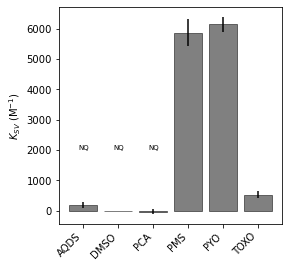

In [6]:
# Index fits by name for easier lookup
o2ns_fits = quencher_fit_df.set_index('name')

# Some of the better quenchers, e.g. toxoflavin, give a non-linear response curve as expected from theory. 
# However, the non-linear model has an additional degree of freedom, it gives much larger errors on the KSV value.
# As such it makes more sense to report value +/- error for the linear model and discuss the non-linearity in the SI.
xs = np.arange(o2ns_fits.index.size)
ys = o2ns_fits['K_SV (/M)']
yerr = o2ns_fits['K_SV err (/M)']

plt.figure(figsize=(4,4))
plt.bar(xs, ys, yerr=yerr, color='grey', edgecolor='k', lw=0.5, ecolor='k')

for i, (idx, row) in enumerate(o2ns_fits.iterrows()):
    if not row.quencher:
        plt.text(i, 2000, 'NQ', ha='center', fontsize=7)

plt.ylabel('$K_{SV}$ (M$^{-1}$)')
plt.xticks(xs, o2ns_fits.index, rotation=45, ha='right')
plt.show()

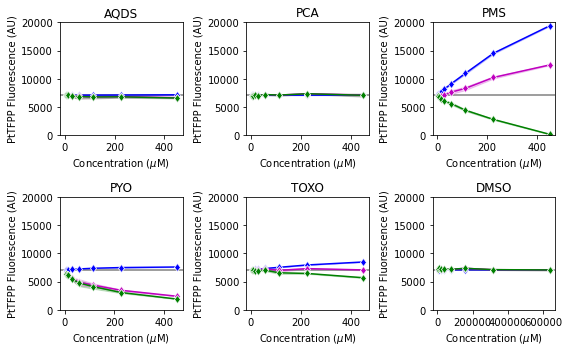

In [7]:
fig, axs = plt.subplots(figsize=(8,5), ncols=3, nrows=2)
flat_axs = axs.flatten()
name_order = ['AQDS', 'PCA', 'PMS', 'PYO', 'TOXO', 'DMSO',]

for qname, my_ax in zip(name_order, flat_axs):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
    
    plt.axhline(pt_alone_fluor.nominal_value, color='grey')
    sns.lineplot(data=qdf_post, x='concentration', y='expected_blanked_pt_fluor', 
                 color='b', marker='d', markersize=6)
    
    sns.lineplot(data=qdf_post, x='concentration', y='blanked_pt_fluor', 
                 color='m', marker='d', markersize=6)
    
    sns.lineplot(data=qdf_post, x='concentration', y='estimated_true_pt_fluor', 
                 color='g', marker='d', markersize=6)
    
    plt.title(qname)
    plt.ylim(0, 20000)
    plt.xlabel('Concentration ($\mu$M)')
    plt.ylabel('PtTFPP Fluorescence (AU)')
    
plt.tight_layout()
plt.savefig('../figures/o2ns_vitro.png', facecolor='w', dpi=600)
plt.show()

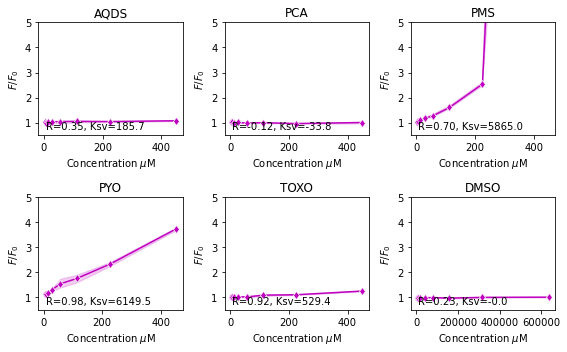

In [8]:
fig, axs = plt.subplots(figsize=(8,5), ncols=3, nrows=2)
flat_axs = axs.flatten()
name_order = ['AQDS', 'PCA', 'PMS', 'PYO', 'TOXO', 'DMSO',]

for qname, my_ax in zip(name_order, flat_axs):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
    
    sns.lineplot(data=qdf_post, x='concentration', y='F0_F_ratio', 
                 color='m', marker='d', markersize=6)
    
    corr = qdf_post.corr().loc['concentration', 'F0_F_ratio']
    slope = o2ns_fits.loc[qname]['K_SV (/M)']
    plt.text(0.05, 0.05, 'R={0:.2f}, Ksv={1:0.1f}'.format(corr, slope),
             transform=my_ax.transAxes)
    
    plt.title(qname)
    plt.ylim(0.5, 5)
    plt.xlabel('Concentration $\mu$M')
    plt.ylabel('$F / F_0$')
    
plt.tight_layout()